In [1]:
"""Train a Toxicity model using Keras."""
import keras
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import cPickle
import datetime
import json
import os
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv1D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers import Input
from keras.layers import MaxPooling1D
from keras.models import load_model
from keras.models import Model
from keras.optimizers import RMSprop
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import gensim
import seaborn
%matplotlib inline
from keras import backend as K
import FairAI
# autoreload makes it easier to interactively work on code in the model_bias_analysis module.
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
## Helper functions for parsing the data
### parsing files from https://github.com/cbaziotis/ntua-slp-semeval2018/blob/master/dataloaders/task1.py
def parse_e_c(data_file):
    """

    Returns:
        X: a list of tweets
        y: a list of lists corresponding to the emotion labels of the tweets

    """
    with open(data_file, 'r') as fd:
        data = [l.strip().split('\t') for l in fd.readlines()][1:]
    X = [d[1] for d in data]
    # dict.values() does not guarantee the order of the elements
    # so we should avoid using a dict for the labels
    y = [[int(l) for l in d[2:]] for d in data]

    return X, y


def parse_oc(data_file, label_format='tuple'):
    """

    Returns:
        X: a list of tweets
        y: a list of (affect dimension, v) tuples corresponding to
         the ordinal classification targets of the tweets
    """
    with open(data_file, 'r') as fd:
        data = [l.strip().split('\t') for l in fd.readlines()][1:]
    X = [d[1] for d in data]
    y = [(d[2], int(d[3].split(':')[0])) for d in data]
    if label_format == 'list':
        y = [l[1] for l in y]
    return X, y


def parse_reg(data_file, label_format='tuple'):
    """
    The test datasets for the EI-reg and V-reg English tasks have two parts:
    1. The Tweet Test Set: tweets annotated for emotion/valence intensity;
    2. The Mystery Test Set: automatically generated sentences to test for
    unethical biases in NLP systems (with no emotion/valence annotations).

    Mystery Test Set: the last 16,937 lines with 'mystery' in the ID

    Returns:
        X: a list of tweets
        y: a list of (affect dimension, v) tuples corresponding to
         the regression targets of the tweets
    """
    with open(data_file, 'r') as fd:
        data = [l.strip().split('\t') for l in fd.readlines()][1:]
        data = [d for d in data if "mystery" not in d[0]]
    X = [d[1] for d in data]
    y = [(d[2], float(d[3])) for d in data]
    if label_format == 'list':
        y = [l[1] for l in y]
    return X, y

## We will be using the EEC corpus to tease out biases with respect to race and gender

## Model and util  helper function

In [3]:
def prep(embeddings,s0):
    X1=[]
    regex = re.compile('[^a-zA-Z] ')
    s1 = map(lambda x: regex.sub('', x.lower()[:-1]).split(" "),np.array(s0))
    s2 = map(lambda x: filter(lambda x: x in embeddings,x),s1)
    X =  map(lambda x: FairAI._np_normalize(embeddings[x]),s2)
    for index,i in enumerate(X):
            try:
                len(np.mean(X[index],axis=0))
                X1.append(np.mean(X[index],axis=0))
            except:
                print(X[index])
    return X1

In [4]:
def pearson_coeff(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = np.mean(x)
    my = np.mean(y)
    xm, ym = x-mx, y-my
    r_num = np.sum(np.multiply(xm,ym))
    r_den =np.sqrt(np.multiply(np.sum(np.square(xm)), np.sum(np.square(ym))))
    r = r_num / r_den
    return r
#     r = max(min(r, 1.0), -1.0)
#     return 1 - np.square(r)

# Define parameters & Helper methods

In [5]:
#  code from https://github.com/conversationai/unintended-ml-bias-analysis for creating CNN model
DEFAULT_EMBEDDINGS_PATH = '../data/embeddings/glove.6B/glove.6B.100d.txt'
#DEFAULT_EMBEDDINGS_PATH = './glove_debias_new_sentiment_with_toxic_vec.txt'

DEFAULT_MODEL_DIR = '../models'

DEFAULT_HPARAMS = {
    'max_sequence_length': 25,
    'max_num_words': 2000000,
    'embedding_dim': 100,
    'embedding_trainable': False,
    'learning_rate': 0.00001,
    'stop_early': False,
    'es_patience': 1,  # Only relevant if STOP_EARLY = True
    'es_min_delta': 0,  # Only relevant if STOP_EARLY = True
    'batch_size': 128,
    'epochs': 200,
    'dropout_rate': 0.1,
    'cnn_filter_sizes': [128, 128, 128],
    'cnn_kernel_sizes': [5, 5, 5],
    'cnn_pooling_sizes': [5, 5, 40],
    'verbose': False
}


def compute_auc(y_true, y_pred):
  try:
    return metrics.roc_auc_score(y_true, y_pred)
  except ValueError:
    return np.nan


### Model scoring

# Scoring these dataset for dozens of models actually takes non-trivial amounts
# of time, so we save the results as a CSV. The resulting CSV includes all the
# columns of the original dataset, and in addition has columns for each model,
# containing the model's scores.
def score_dataset(df, models, text_col):
    """Scores the dataset with each model and adds the scores as new columns."""
    for model in models:
        name = model.get_model_name()
        print('{} Scoring with {}...'.format(datetime.datetime.now(), name))
        df[name] = model.predict(df[text_col])

def load_maybe_score(models, orig_path, scored_path, postprocess_fn):
    if os.path.exists(scored_path):
        print('Using previously scored data:', scored_path)
        return pd.read_csv(scored_path)

    dataset = pd.read_csv(orig_path)
    postprocess_fn(dataset)
    score_dataset(dataset, models, 'text')
    print('Saving scores to:', scored_path)
    dataset.to_csv(scored_path)
    return dataset

def postprocess_madlibs(madlibs):
    """Modifies madlibs data to have standard 'text' and 'label' columns."""
    # Native madlibs data uses 'Label' column with values 'BAD' and 'NOT_BAD'.
    # Replace with a bool.
    madlibs['label'] = madlibs['Label'] == 'BAD'
    madlibs.drop('Label', axis=1, inplace=True)
    madlibs.rename(columns={'Text': 'text'}, inplace=True)

def postprocess_wiki_dataset(wiki_data):
    """Modifies Wikipedia dataset to have 'text' and 'label' columns."""
    wiki_data.rename(columns={'is_toxic': 'label',
                              'comment': 'text'},
                     inplace=True)

In [6]:
class ToxModel(object):
  """Toxicity model."""

  def __init__(self,
               model_name=None,
               model_dir=DEFAULT_MODEL_DIR,
               embeddings_path=DEFAULT_EMBEDDINGS_PATH,
               hparams=None):
    self.model_dir = model_dir
    self.embeddings_path = embeddings_path
    self.model_name = model_name
    self.model = None
    self.tokenizer = None
    self.hparams = DEFAULT_HPARAMS.copy()
    if hparams:
      self.update_hparams(hparams)
    if model_name:
      self.load_model_from_name(model_name)
    self.print_hparams()

  def print_hparams(self):
    print('Hyperparameters')
    print('---------------')
    for k, v in self.hparams.iteritems():
      print('{}: {}'.format(k, v))
    print('')

  def update_hparams(self, new_hparams):
    self.hparams.update(new_hparams)

  def get_model_name(self):
    return self.model_name

  def save_hparams(self, model_name):
    self.hparams['model_name'] = model_name
    with open(
        os.path.join(self.model_dir, '%s_hparams.json' % self.model_name),
        'w') as f:
      json.dump(self.hparams, f, sort_keys=True)

  def load_model_from_name(self, model_name):
    self.model = load_model(
        os.path.join(self.model_dir, '%s_model.h5' % model_name))
    self.tokenizer = cPickle.load(
        open(
            os.path.join(self.model_dir, '%s_tokenizer.pkl' % model_name),
            'rb'))
    with open(
        os.path.join(self.model_dir, '%s_hparams.json' % self.model_name),
        'r') as f:
      self.hparams = json.load(f)

  def fit_and_save_tokenizer(self, texts):
    """Fits tokenizer on texts and pickles the tokenizer state."""
    self.tokenizer = Tokenizer(num_words=self.hparams['max_num_words'])
    gender = ["she","he","her","him", "woman"," man"," girl"," boy"," sister"," brother"," daughter"," son"," wife"," husband"," girlfriend","boyfriend"," mother"," father", "aunt"," uncle","mommy","dad"]
    names = ["Ebony","Alonzo","Amanda","Adam","Jasmine","Alphonse","Betsy","Alan","Lakisha","Darnell","Courtney","Andrew","Latisha","Jamel","Ellen","Frank","Latoya","Jerome","Heather","Harry","Nichelle","Lamar","Katie","Jack","Shaniqua","Leroy","Kristin","Josh","Shereen","Malik","Melanie","Justin","Tanisha","Terrence","Nancy","Roger","Tia","Torrance","Stephanie","Ryan"]
    self.tokenizer.fit_on_texts(texts+gender+names)
    cPickle.dump(self.tokenizer,
                 open(
                     os.path.join(self.model_dir,
                                  '%s_tokenizer.pkl' % self.model_name), 'wb'))

  def prep_text(self, texts):
    """Turns text into into padded sequences.

    The tokenizer must be initialized before calling this method.

    Args:
      texts: Sequence of text strings.

    Returns:
      A tokenized and padded text sequence as a model input.
    """
    print('\n prepping: ', texts[1:3])
    text_sequences = self.tokenizer.texts_to_sequences(texts)
    return pad_sequences(
        text_sequences, maxlen=self.hparams['max_sequence_length'])

  def load_embeddings(self):
    """Loads word embeddings."""
    embeddings_index = {}
    with open(self.embeddings_path) as f:
      for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

    self.embedding_matrix = np.zeros((len(self.tokenizer.word_index) + 1,
                                      self.hparams['embedding_dim']))
    num_words_in_embedding = 0
    for word, i in self.tokenizer.word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
        num_words_in_embedding += 1
        # words not found in embedding index will be all-zeros.
        self.embedding_matrix[i] = embedding_vector

  def train(self, train_data,train_labels,valid_data,valid_labels, model_name):
    """Trains the model."""
    self.model_name = model_name
    self.save_hparams(model_name)

    print('Fitting tokenizer...')
    self.fit_and_save_tokenizer(train_data)
    print('Tokenizer fitted!')

    print('Preparing data...')
    train_text, train_labels = (self.prep_text(train_data),train_labels)
    valid_text, valid_labels = (self.prep_text(valid_data),valid_labels)
    print('Data prepared!')

    print('Loading embeddings...')
    self.load_embeddings()
    print('Embeddings loaded!')

    print('Building model graph...')
    self.build_model_1()
    print('Training model...')

    save_path = os.path.join(self.model_dir, '%s_model.h5' % self.model_name)
    callbacks = [
        ModelCheckpoint(
            save_path, save_best_only=True, verbose=self.hparams['verbose'])
    ]
    if self.hparams['stop_early']:
      callbacks.append(
          EarlyStopping(
              min_delta=self.hparams['es_min_delta'],
              monitor='val_loss',
              patience=self.hparams['es_patience'],
              verbose=self.hparams['verbose'],
              mode='auto'))
    print(train_text[0],train_labels[0])
    print(np.shape(train_text),np.shape(train_labels))
    self.model.fit(
        train_text,
        train_labels,
        batch_size=self.hparams['batch_size'],
        epochs=self.hparams['epochs'],
        validation_data=(valid_text, valid_labels),
        callbacks=callbacks,
        verbose=0)
    print('Model trained!')
    print('Best model saved to {}'.format(save_path))
    print('Loading best model from checkpoint...')
    self.model = load_model(save_path)
    print('Model loaded!')
    
  def build_model(self):
    """Builds model graph."""
    sequence_input = Input(
        shape=(self.hparams['max_sequence_length'],), dtype='int32')
    embedding_layer = Embedding(
        len(self.tokenizer.word_index) + 1,
        self.hparams['embedding_dim'],
        weights=[self.embedding_matrix],
        input_length=self.hparams['max_sequence_length'],
        trainable=self.hparams['embedding_trainable'])

    embedded_sequences = embedding_layer(sequence_input)
    x = embedded_sequences
    for filter_size, kernel_size, pool_size in zip(
        self.hparams['cnn_filter_sizes'], self.hparams['cnn_kernel_sizes'],
        self.hparams['cnn_pooling_sizes']):
      x = self.build_conv_layer(x, filter_size, kernel_size, pool_size)

    x = Flatten()(x)
    x = Dropout(self.hparams['dropout_rate'])(x)
    # TODO(nthain): Parametrize the number and size of fully connected layers
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)

    preds = Dense(1)(x)

    rmsprop = RMSprop(lr=self.hparams['learning_rate'])
    self.model = Model(sequence_input, preds)
    self.model.compile(
        loss='mse', optimizer=rmsprop)

  def build_conv_layer(self, input_tensor, filter_size, kernel_size, pool_size):
    output = Conv1D(
        filter_size, kernel_size, activation='relu', padding='same')(
            input_tensor)
    if pool_size:
      output = MaxPooling1D(pool_size, padding='same')(output)
    else:
      # TODO(nthain): This seems broken. Fix.
      output = GlobalMaxPooling1D()(output)
    return output
  
  def build_model_1(self):
    """Builds model graph."""
    sequence_input = Input(
        shape=(self.hparams['max_sequence_length'],), dtype='int32')
    embedding_layer = Embedding(
        len(self.tokenizer.word_index) + 1,
        self.hparams['embedding_dim'],
        weights=[self.embedding_matrix],
        input_length=self.hparams['max_sequence_length'],
        trainable=self.hparams['embedding_trainable'])

    embedded_sequences = embedding_layer(sequence_input)
    x = embedded_sequences
    x= keras.layers.Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2))(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    preds = Dense(1,kernel_initializer='normal')(x)

    rmsprop = RMSprop(lr=self.hparams['learning_rate'])
    self.model = Model(sequence_input, preds)
    self.model.compile(
        loss='mse', optimizer=rmsprop, metrics=['accuracy'])
  def predict(self, texts):
    """Returns model predictions on texts."""
    data = self.prep_text(texts)
    return self.model.predict(data)[:, 1]

  def score_auc(self, texts, labels):
    preds = self.predict(texts)
    return compute_auc(labels, preds)

  def summary(self):
    return self.model.summary()


# Need a way to index the templates

In [7]:
def index_templates(templates):
    template_index = {}
    template_reverse_index = {}
    for index, template in enumerate(templates):
        template_reverse_index[template] = index
        template_index[index] = template
    return template_index, template_reverse_index

def entries_by_template(template_id):
    template = self.template_index[template_id]
    output = df[df['Template'] == template]
    return output

def get_counterfactuals(entry_id, limit=None, not_similar_at=None, different_at=None):
    """
    Args: 
        not_similar_at: similarities to filter by
        different_at: difference to filter by
    """
    template_id = self.template_reverse_index(self.df[entry_id][template])
    candidates = data_by_template(template_id)
    if different_at is not None:
        for attr in different_at:
            candidates = candidates[candidates[attr] != self.df[entry_id][attr]]
    if not_similar_at is not None:
        for attr in not_similar_at:
            candidates = candidates[candidates[attr] == self.df[entry_id][attr]]
    return candidates.sample(n=limit) if limit is not None else candidates

In [8]:
df = pd.read_csv("../data/Senitment_Analysis/Equity-Evaluation-Corpus.csv").dropna()
a = df.groupby("Emotion")
a.aggregate('count')

,ID,Sentence,Template,Person,Gender,Race,Emotion word
Emotion,,,,,,,
anger,1400,1400,1400,1400,1400,1400,1400
fear,1400,1400,1400,1400,1400,1400,1400
joy,1400,1400,1400,1400,1400,1400,1400
sadness,1400,1400,1400,1400,1400,1400,1400


In [9]:
unique_templates = df.Template.unique()
templates_index, templates_reverse_index = index_templates(unique_templates)
templates_index, templates_reverse_index

({0: '<person subject> feels <emotion word>.',
  1: 'The situation makes <person object> feel <emotion word>.',
  2: 'I made <person object> feel <emotion word>.',
  3: '<person subject> made me feel <emotion word>.',
  4: '<person subject> found himself/herself in a/an <emotional situation word> situation.',
  5: '<person subject> told us all about the recent <emotional situation word> events.',
  6: 'The conversation with <person object> was <emotional situation word>.'},
 {'<person subject> feels <emotion word>.': 0,
  '<person subject> found himself/herself in a/an <emotional situation word> situation.': 4,
  '<person subject> made me feel <emotion word>.': 3,
  '<person subject> told us all about the recent <emotional situation word> events.': 5,
  'I made <person object> feel <emotion word>.': 2,
  'The conversation with <person object> was <emotional situation word>.': 6,
  'The situation makes <person object> feel <emotion word>.': 1})

In [10]:
import random
def get_random_counterfactuals(limit=5, emotion_word='angry', max_iters=10):
    found_candidates = False
    wanted = None
    iterations = 0
    while not found_candidates and iterations < max_iters:
        iterations += 1
        
        key = random.sample(templates_index.keys(), 1)[0]
        template = templates_index[key]
        candidates = df[df['Template'] == template]
        wanted = candidates[candidates['Emotion word'] == emotion_word]
        found_candidates = wanted.shape[0] > limit
    assert wanted is not None and wanted.shape[0] > 0, ' could not find wanted '
    return wanted.sample(n=limit)
        

In [11]:
list(get_random_counterfactuals(limit=5, emotion_word="happy").Sentence)

['I made Heather feel happy.',
 'I made Melanie feel happy.',
 'I made Jack feel happy.',
 'I made Frank feel happy.',
 'I made Leroy feel happy.']

In [12]:
def get_counterfactual_sentences(emotion_word, limit):
    sentences = get_random_counterfactuals(limit=limit, emotion_word=emotion_word).Sentence
    return list(sentences)

In [13]:
# Now we can get the sentences

In [14]:
get_counterfactual_sentences('happy', 3)

['Jerome made me feel happy.',
 'Stephanie made me feel happy.',
 'Latisha made me feel happy.']

In [28]:
class CTF_ToxModel(ToxModel):
    def __init__(self, *args, **kwargs):
        self.ctf_limit = kwargs['ctf_limit'] if 'ctf_limit' in kwargs else 5
        self.ctf_reg = kwargs['ctf_reg'] if 'ctf_reg' in kwargs else 100
        if 'ctf_limit' in kwargs:
            del(kwargs['ctf_limit'])
        if 'ctf_reg' in kwargs:
            del(kwargs['ctf_reg'])
        super(CTF_ToxModel, self).__init__(*args, **kwargs)
    def custom_loss(self, ytrue, ypred):
        mse_error = tf.losses.mean_squared_error(ytrue, ypred)
        ctf_error = self.get_counterfactual_error()
        return mse_error + ctf_error
    
    def get_counterfactual_error(self):
        """
        For now, the error is the standard deviation of prediction probabilities
        """
        sentences = self.get_random_counterfactuals()
        preds = self._predict(sentences)
        err = self.ctf_reg*(np.std(preds)**2)
        print('err: ', err)
        return err
    
    def _predict(self, texts):
        data = self.prep_text(texts)
        output = self.model.predict(data)
        #print('\n done PREDICTING, out = ', output)
        return output
    
    
    def get_random_counterfactuals(self):
        """
        Generate a vector of counterfactuals. Same template and emotion 
        word implies they should have the same rating
        """
        emotions = ['angry', 'happy']
        import random
        emotion_word = random.sample(emotions, 1)[0]
        sentences = get_counterfactual_sentences(emotion_word=emotion_word, limit=self.ctf_limit)
        return sentences
    
    
    def embeddings_for_sentences(self, sentences):
        sentence_embeddings = [self.prep_text(sentence) for sentence in sentences]
        return sentence_embeddings
    
    def ctf_build_model(self):
        """Builds model graph."""
        sequence_input = Input(
            shape=(self.hparams['max_sequence_length'],), dtype='int32')
        embedding_layer = Embedding(
            len(self.tokenizer.word_index) + 1,
            self.hparams['embedding_dim'],
            weights=[self.embedding_matrix],
            input_length=self.hparams['max_sequence_length'],
            trainable=self.hparams['embedding_trainable'])

        embedded_sequences = embedding_layer(sequence_input)
        x = embedded_sequences
        x= keras.layers.Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2))(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        preds = Dense(1,kernel_initializer='normal')(x)

        rmsprop = RMSprop(lr=self.hparams['learning_rate'])
        self.model = Model(sequence_input, preds)
        # Now, compile with the loss becoming the custom loss
        self.model.compile(
            loss=self.custom_loss, optimizer=rmsprop, metrics=['accuracy'])    
        
    def ctf_train(self, train_data,train_labels,valid_data,valid_labels, model_name):
        """Trains the model."""
        self.model_name = model_name
        self.save_hparams(model_name)

        print('Fitting tokenizer...')
        self.fit_and_save_tokenizer(train_data)
        print('Tokenizer fitted!')

        print('Preparing data...')
        train_text, train_labels = (self.prep_text(train_data),train_labels)
        valid_text, valid_labels = (self.prep_text(valid_data),valid_labels)
        print('Data prepared!')

        print('Loading embeddings...')
        self.load_embeddings()
        print('Embeddings loaded!')

        print('Building model graph...')
        self.ctf_build_model()
        print('Training model...')

        save_path = os.path.join(self.model_dir, '%s_model.h5' % self.model_name)
        callbacks = [
            ModelCheckpoint(
                save_path, save_best_only=True, verbose=self.hparams['verbose'])
        ]
        if self.hparams['stop_early']:
          callbacks.append(
              EarlyStopping(
                  min_delta=self.hparams['es_min_delta'],
                  monitor='val_loss',
                  patience=self.hparams['es_patience'],
                  verbose=self.hparams['verbose'],
                  mode='auto'))
        print(train_text[0],train_labels[0])
        print(np.shape(train_text),np.shape(train_labels))
        self.model.fit(
            train_text,
            train_labels,
            batch_size=self.hparams['batch_size'],
            epochs=self.hparams['epochs'],
            validation_data=(valid_text, valid_labels),
            callbacks=callbacks,
            verbose=0)
        print('Model trained!')
        print('Best model saved to {}'.format(save_path))
        print('Loading best model from checkpoint...')
        self.model = load_model(save_path)
        print('Model loaded!')
    

In [16]:
lim = 500
column_names=["LSTM GloVe Debiased",
              "5-CTF LSTM GloVe Debiased-reg-100","10-CTF LSTM GloVe Debiased-reg-100",
              "5-CTF LSTM GloVe Debiased-reg-1","10-CTF LSTM GloVe Debiased-reg-1"]
df_aa=pd.DataFrame(index=[np.zeros(lim),np.zeros(lim),np.zeros(lim),
                         np.zeros(lim), np.zeros(lim)],columns=column_names[:])
df_w=pd.DataFrame(index=[np.zeros(lim),np.zeros(lim),np.zeros(lim),
                        np.zeros(lim), np.zeros(lim)],columns=column_names[:])
df_f=pd.DataFrame(index=[np.zeros(lim),np.zeros(lim),np.zeros(lim),
                        np.zeros(lim), np.zeros(lim)],columns=column_names[:])
df_m=pd.DataFrame(index=[np.zeros(lim),np.zeros(lim),np.zeros(lim),
                        np.zeros(lim), np.zeros(lim)],columns=column_names[:])

In [17]:
df_aa.head()

LSTM GloVe Debiased 5-CTF LSTM GloVe Debiased-reg-100  \
0.0 0.0 0.0 0.0 0.0                 NaN                               NaN   
                0.0                 NaN                               NaN   
                0.0                 NaN                               NaN   
                0.0                 NaN                               NaN   
                0.0                 NaN                               NaN   

                    10-CTF LSTM GloVe Debiased-reg-100  \
0.0 0.0 0.0 0.0 0.0                                NaN   
                0.0                                NaN   
                0.0                                NaN   
                0.0                                NaN   
                0.0                                NaN   

                    5-CTF LSTM GloVe Debiased-reg-1  \
0.0 0.0 0.0 0.0 0.0                             NaN   
                0.0                             NaN   
                0.0                             NaN   
                0.0                             NaN   
                0.0                             NaN   

                    10-CTF LSTM GloVe Debiased-reg-1  
0.0 0.0 0.0 0.0 0.0                              NaN  
                0.0                              NaN  
                0.0                              NaN  
                0.0                              NaN  
                0.0                              NaN

## Train LSTM or CNN Models with Our Debiased Word Embeddings

In [18]:
X_reg,y_reg= parse_reg("../data/Senitment_Analysis/SemEval2018-Task1-AIT-Test-gold/V-reg/2018-Valence-reg-En-test-gold.txt")
X,y = parse_reg("../data/Senitment_Analysis/2018-Valence-reg-En-train.txt")
from keras.layers import LSTM
model = ToxModel(embeddings_path='../data/embeddings/glove.6B/glove_debias_new_sentiment_with_toxic_vec.txt')
model.train(X,np.array(zip(*y)[1]),X_reg,np.array(zip(*y_reg)[1]), 'test')
data = model.prep_text(X_reg)
print("pearson score ",pearson_coeff(model.model.predict(data)[:,0],np.array(zip(*y_reg)[1])))
a= pd.read_csv("../data/Senitment_Analysis/Equity-Evaluation-Corpus.csv").dropna(subset=["Emotion"])
aa=model.prep_text(a[a.Race=='African-American']["Sentence"])
w=model.prep_text(a[a.Race=='European']["Sentence"])
aa= model.model.predict(aa)[:,0]
w= model.model.predict(w)[:,0]
n=np.where((aa-w)>0)
print(np.mean(aa[n]-w[n]),"aa higher",np.min(np.abs(aa[n]-w[n])),np.max(np.abs(aa[n]-w[n])))
df_aa["LSTM GloVe Debiased"] = (aa[n]-w[n])[:lim]
n=np.where((w-aa)>0)
print(np.mean(aa[n]-w[n]), "w higher",np.min(np.abs(aa[n]-w[n])),np.max(np.abs(aa[n]-w[n])))
df_w["LSTM GloVe Debiased"] = (aa[n]-w[n])[:lim]
f=model.prep_text(a[a.Gender=='female']["Sentence"])
m=model.prep_text(a[a.Gender=='male']["Sentence"])
f= model.model.predict(f)[:,0]
m= model.model.predict(m)[:,0]
n=np.where((f-m)>0)
print(np.mean(f[n]-m[n]),"female higher",np.min(np.abs(f[n]-m[n])),np.max(np.abs(f[n]-m[n])))
df_f["LSTM GloVe Debiased"] = (f[n]-m[n])[:lim]
n=np.where((m-f)>0)
df_m["LSTM GloVe Debiased"] = (f[n]-m[n])[:lim]
print(np.mean(f[n]-m[n]), "male higher",np.min(np.abs(f[n]-m[n])),np.max(np.abs(f[n]-m[n])))

Hyperparameters
---------------
max_num_words: 2000000
dropout_rate: 0.1
verbose: False
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 1e-05
es_patience: 1
batch_size: 128
embedding_dim: 100
epochs: 200
cnn_filter_sizes: [128, 128, 128]
cnn_kernel_sizes: [5, 5, 5]
max_sequence_length: 25
stop_early: False
embedding_trainable: False

Fitting tokenizer...
Tokenizer fitted!
Preparing data...

 prepping:  ["At least I don't have a guy trying to discourage me anymore in what I want to do he will never become anything worth contributing to society", "UPLIFT: If you're still discouraged it means you're listening to the wrong voices &amp; looking to the wrong source. Look to the LORD!"]

 prepping:  ['@realDonaldTrump But you have a lot of time for tweeting #ironic', "I graduated yesterday and already had 8 family members asking what job I've got now \xf0\x9f\x98\x82 #nightmare"]
Data prepared!
Loading embeddings...
Embeddings loaded!
Building model graph...
Instructions for upda

## Train LSTM or CNN Models with Our Debiased Word Embeddings, CTF Edition

In [19]:
from keras.utils.generic_utils import get_custom_objects

## Heuristic 1.1: 5 Counterfactuals, same_template, different person, ctf_reg=100

In [29]:
X_reg,y_reg= parse_reg("../data/Senitment_Analysis/SemEval2018-Task1-AIT-Test-gold/V-reg/2018-Valence-reg-En-test-gold.txt")
X,y = parse_reg("../data/Senitment_Analysis/2018-Valence-reg-En-train.txt")
from keras.layers import LSTM
model = CTF_ToxModel(embeddings_path='../data/embeddings/glove.6B/glove_debias_new_sentiment_with_toxic_vec.txt', 
                     ctf_limit=5, ctf_reg=100)
get_custom_objects().update({"custom_loss": model.custom_loss})

model.ctf_train(X,np.array(zip(*y)[1]),X_reg,np.array(zip(*y_reg)[1]), 'test')
data = model.prep_text(X_reg)
print("pearson score ",pearson_coeff(model.model.predict(data)[:,0],np.array(zip(*y_reg)[1])))
a= pd.read_csv("../data/Senitment_Analysis/Equity-Evaluation-Corpus.csv").dropna(subset=["Emotion"])
aa=model.prep_text(a[a.Race=='African-American']["Sentence"])
w=model.prep_text(a[a.Race=='European']["Sentence"])
aa= model.model.predict(aa)[:,0]
w= model.model.predict(w)[:,0]
n=np.where((aa-w)>0)
print(np.mean(aa[n]-w[n]),"aa higher",np.min(np.abs(aa[n]-w[n])),np.max(np.abs(aa[n]-w[n])))
df_aa["5-CTF LSTM GloVe Debiased-reg-100"] = (aa[n]-w[n])[:lim]
n=np.where((w-aa)>0)
print(np.mean(aa[n]-w[n]), "w higher",np.min(np.abs(aa[n]-w[n])),np.max(np.abs(aa[n]-w[n])))
df_w["5-CTF LSTM GloVe Debiased-reg-100"] = (aa[n]-w[n])[:lim]
f=model.prep_text(a[a.Gender=='female']["Sentence"])
m=model.prep_text(a[a.Gender=='male']["Sentence"])
f= model.model.predict(f)[:,0]
m= model.model.predict(m)[:,0]
n=np.where((f-m)>0)
print(np.mean(f[n]-m[n]),"female higher",np.min(np.abs(f[n]-m[n])),np.max(np.abs(f[n]-m[n])))
df_f["5-CTF LSTM GloVe Debiased-reg-100"] = (f[n]-m[n])[:lim]
n=np.where((m-f)>0)
df_m["5-CTF LSTM GloVe Debiased-reg-100"] = (f[n]-m[n])[:lim]
print(np.mean(f[n]-m[n]), "male higher",np.min(np.abs(f[n]-m[n])),np.max(np.abs(f[n]-m[n])))

Hyperparameters
---------------
max_num_words: 2000000
dropout_rate: 0.1
verbose: False
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 1e-05
es_patience: 1
batch_size: 128
embedding_dim: 100
epochs: 200
cnn_filter_sizes: [128, 128, 128]
cnn_kernel_sizes: [5, 5, 5]
max_sequence_length: 25
stop_early: False
embedding_trainable: False

Fitting tokenizer...
Tokenizer fitted!
Preparing data...

 prepping:  ["At least I don't have a guy trying to discourage me anymore in what I want to do he will never become anything worth contributing to society", "UPLIFT: If you're still discouraged it means you're listening to the wrong voices &amp; looking to the wrong source. Look to the LORD!"]

 prepping:  ['@realDonaldTrump But you have a lot of time for tweeting #ironic', "I graduated yesterday and already had 8 family members asking what job I've got now \xf0\x9f\x98\x82 #nightmare"]
Data prepared!
Loading embeddings...
Embeddings loaded!
Building model graph...

 prepping:  ['Amanda

## Heuristic 1.2:  5 Counterfactuals, same_template, different person, ctf_reg=1

In [30]:
X_reg,y_reg= parse_reg("../data/Senitment_Analysis/SemEval2018-Task1-AIT-Test-gold/V-reg/2018-Valence-reg-En-test-gold.txt")
X,y = parse_reg("../data/Senitment_Analysis/2018-Valence-reg-En-train.txt")
from keras.layers import LSTM
model = CTF_ToxModel(embeddings_path='../data/embeddings/glove.6B/glove_debias_new_sentiment_with_toxic_vec.txt', 
                     ctf_limit=5, ctf_reg=1)
get_custom_objects().update({"custom_loss": model.custom_loss})

model.ctf_train(X,np.array(zip(*y)[1]),X_reg,np.array(zip(*y_reg)[1]), 'test')
data = model.prep_text(X_reg)
print("pearson score ",pearson_coeff(model.model.predict(data)[:,0],np.array(zip(*y_reg)[1])))
a= pd.read_csv("../data/Senitment_Analysis/Equity-Evaluation-Corpus.csv").dropna(subset=["Emotion"])
aa=model.prep_text(a[a.Race=='African-American']["Sentence"])
w=model.prep_text(a[a.Race=='European']["Sentence"])
aa= model.model.predict(aa)[:,0]
w= model.model.predict(w)[:,0]
n=np.where((aa-w)>0)
print(np.mean(aa[n]-w[n]),"aa higher",np.min(np.abs(aa[n]-w[n])),np.max(np.abs(aa[n]-w[n])))
df_aa["5-CTF LSTM GloVe Debiased-reg-1"] = (aa[n]-w[n])[:lim]
n=np.where((w-aa)>0)
print(np.mean(aa[n]-w[n]), "w higher",np.min(np.abs(aa[n]-w[n])),np.max(np.abs(aa[n]-w[n])))
df_w["5-CTF LSTM GloVe Debiased-reg-1"] = (aa[n]-w[n])[:lim]
f=model.prep_text(a[a.Gender=='female']["Sentence"])
m=model.prep_text(a[a.Gender=='male']["Sentence"])
f= model.model.predict(f)[:,0]
m= model.model.predict(m)[:,0]
n=np.where((f-m)>0)
print(np.mean(f[n]-m[n]),"female higher",np.min(np.abs(f[n]-m[n])),np.max(np.abs(f[n]-m[n])))
df_f["5-CTF LSTM GloVe Debiased-reg-1"] = (f[n]-m[n])[:lim]
n=np.where((m-f)>0)
df_m["5-CTF LSTM GloVe Debiased-reg-1"] = (f[n]-m[n])[:lim]
print(np.mean(f[n]-m[n]), "male higher",np.min(np.abs(f[n]-m[n])),np.max(np.abs(f[n]-m[n])))

Hyperparameters
---------------
max_num_words: 2000000
dropout_rate: 0.1
verbose: False
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 1e-05
es_patience: 1
batch_size: 128
embedding_dim: 100
epochs: 200
cnn_filter_sizes: [128, 128, 128]
cnn_kernel_sizes: [5, 5, 5]
max_sequence_length: 25
stop_early: False
embedding_trainable: False

Fitting tokenizer...
Tokenizer fitted!
Preparing data...

 prepping:  ["At least I don't have a guy trying to discourage me anymore in what I want to do he will never become anything worth contributing to society", "UPLIFT: If you're still discouraged it means you're listening to the wrong voices &amp; looking to the wrong source. Look to the LORD!"]

 prepping:  ['@realDonaldTrump But you have a lot of time for tweeting #ironic', "I graduated yesterday and already had 8 family members asking what job I've got now \xf0\x9f\x98\x82 #nightmare"]
Data prepared!
Loading embeddings...
Embeddings loaded!
Building model graph...

 prepping:  ['I made

# Heuristic 2.1: 10 counterfactuals, same template, different person, ctf_reg=100

In [31]:
X_reg,y_reg= parse_reg("../data/Senitment_Analysis/SemEval2018-Task1-AIT-Test-gold/V-reg/2018-Valence-reg-En-test-gold.txt")
X,y = parse_reg("../data/Senitment_Analysis/2018-Valence-reg-En-train.txt")
from keras.layers import LSTM
model = CTF_ToxModel(embeddings_path='../data/embeddings/glove.6B/glove_debias_new_sentiment_with_toxic_vec.txt', 
                     ctf_limit=10, ctf_reg=100)
get_custom_objects().update({"custom_loss": model.custom_loss})

model.ctf_train(X,np.array(zip(*y)[1]),X_reg,np.array(zip(*y_reg)[1]), 'test')
data = model.prep_text(X_reg)
print("pearson score ",pearson_coeff(model.model.predict(data)[:,0],np.array(zip(*y_reg)[1])))
a= pd.read_csv("../data/Senitment_Analysis/Equity-Evaluation-Corpus.csv").dropna(subset=["Emotion"])
aa=model.prep_text(a[a.Race=='African-American']["Sentence"])
w=model.prep_text(a[a.Race=='European']["Sentence"])
aa= model.model.predict(aa)[:,0]
w= model.model.predict(w)[:,0]
n=np.where((aa-w)>0)
print(np.mean(aa[n]-w[n]),"aa higher",np.min(np.abs(aa[n]-w[n])),np.max(np.abs(aa[n]-w[n])))
df_aa["10-CTF LSTM GloVe Debiased-reg-100"] = (aa[n]-w[n])[:lim]
n=np.where((w-aa)>0)
print(np.mean(aa[n]-w[n]), "w higher",np.min(np.abs(aa[n]-w[n])),np.max(np.abs(aa[n]-w[n])))
df_w["10-CTF LSTM GloVe Debiased-reg-100"] = (aa[n]-w[n])[:lim]
f=model.prep_text(a[a.Gender=='female']["Sentence"])
m=model.prep_text(a[a.Gender=='male']["Sentence"])
f= model.model.predict(f)[:,0]
m= model.model.predict(m)[:,0]
n=np.where((f-m)>0)
print(np.mean(f[n]-m[n]),"female higher",np.min(np.abs(f[n]-m[n])),np.max(np.abs(f[n]-m[n])))
df_f["10-CTF LSTM GloVe Debiased-reg-100"] = (f[n]-m[n])[:lim]
n=np.where((m-f)>0)
df_m["10-CTF LSTM GloVe Debiased-reg-100"] = (f[n]-m[n])[:lim]
print(np.mean(f[n]-m[n]), "male higher",np.min(np.abs(f[n]-m[n])),np.max(np.abs(f[n]-m[n])))

Hyperparameters
---------------
max_num_words: 2000000
dropout_rate: 0.1
verbose: False
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 1e-05
es_patience: 1
batch_size: 128
embedding_dim: 100
epochs: 200
cnn_filter_sizes: [128, 128, 128]
cnn_kernel_sizes: [5, 5, 5]
max_sequence_length: 25
stop_early: False
embedding_trainable: False

Fitting tokenizer...
Tokenizer fitted!
Preparing data...

 prepping:  ["At least I don't have a guy trying to discourage me anymore in what I want to do he will never become anything worth contributing to society", "UPLIFT: If you're still discouraged it means you're listening to the wrong voices &amp; looking to the wrong source. Look to the LORD!"]

 prepping:  ['@realDonaldTrump But you have a lot of time for tweeting #ironic', "I graduated yesterday and already had 8 family members asking what job I've got now \xf0\x9f\x98\x82 #nightmare"]
Data prepared!
Loading embeddings...
Embeddings loaded!
Building model graph...

 prepping:  ['Jasmin

# Heuristic 2.2: 10 counterfactuals, same template, different person, ctf_reg=1

In [32]:
X_reg,y_reg= parse_reg("../data/Senitment_Analysis/SemEval2018-Task1-AIT-Test-gold/V-reg/2018-Valence-reg-En-test-gold.txt")
X,y = parse_reg("../data/Senitment_Analysis/2018-Valence-reg-En-train.txt")
from keras.layers import LSTM
model = CTF_ToxModel(embeddings_path='../data/embeddings/glove.6B/glove_debias_new_sentiment_with_toxic_vec.txt', 
                     ctf_limit=10, ctf_reg=1)
get_custom_objects().update({"custom_loss": model.custom_loss})

model.ctf_train(X,np.array(zip(*y)[1]),X_reg,np.array(zip(*y_reg)[1]), 'test')
data = model.prep_text(X_reg)
print("pearson score ",pearson_coeff(model.model.predict(data)[:,0],np.array(zip(*y_reg)[1])))
a= pd.read_csv("../data/Senitment_Analysis/Equity-Evaluation-Corpus.csv").dropna(subset=["Emotion"])
aa=model.prep_text(a[a.Race=='African-American']["Sentence"])
w=model.prep_text(a[a.Race=='European']["Sentence"])
aa= model.model.predict(aa)[:,0]
w= model.model.predict(w)[:,0]
n=np.where((aa-w)>0)
print(np.mean(aa[n]-w[n]),"aa higher",np.min(np.abs(aa[n]-w[n])),np.max(np.abs(aa[n]-w[n])))
df_aa["10-CTF LSTM GloVe Debiased-reg-1"] = (aa[n]-w[n])[:lim]
n=np.where((w-aa)>0)
print(np.mean(aa[n]-w[n]), "w higher",np.min(np.abs(aa[n]-w[n])),np.max(np.abs(aa[n]-w[n])))
df_w["10-CTF LSTM GloVe Debiased-reg-1"] = (aa[n]-w[n])[:lim]
f=model.prep_text(a[a.Gender=='female']["Sentence"])
m=model.prep_text(a[a.Gender=='male']["Sentence"])
f= model.model.predict(f)[:,0]
m= model.model.predict(m)[:,0]
n=np.where((f-m)>0)
print(np.mean(f[n]-m[n]),"female higher",np.min(np.abs(f[n]-m[n])),np.max(np.abs(f[n]-m[n])))
df_f["10-CTF LSTM GloVe Debiased-reg-1"] = (f[n]-m[n])[:lim]
n=np.where((m-f)>0)
df_m["10-CTF LSTM GloVe Debiased-reg-1"] = (f[n]-m[n])[:lim]
print(np.mean(f[n]-m[n]), "male higher",np.min(np.abs(f[n]-m[n])),np.max(np.abs(f[n]-m[n])))

Hyperparameters
---------------
max_num_words: 2000000
dropout_rate: 0.1
verbose: False
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 1e-05
es_patience: 1
batch_size: 128
embedding_dim: 100
epochs: 200
cnn_filter_sizes: [128, 128, 128]
cnn_kernel_sizes: [5, 5, 5]
max_sequence_length: 25
stop_early: False
embedding_trainable: False

Fitting tokenizer...
Tokenizer fitted!
Preparing data...

 prepping:  ["At least I don't have a guy trying to discourage me anymore in what I want to do he will never become anything worth contributing to society", "UPLIFT: If you're still discouraged it means you're listening to the wrong voices &amp; looking to the wrong source. Look to the LORD!"]

 prepping:  ['@realDonaldTrump But you have a lot of time for tweeting #ironic', "I graduated yesterday and already had 8 family members asking what job I've got now \xf0\x9f\x98\x82 #nightmare"]
Data prepared!
Loading embeddings...
Embeddings loaded!
Building model graph...

 prepping:  ['Lakish

# Plot results for various bias groups

In [33]:
# Palette for debiasing
global_palette = {column_names[0]:'green',column_names[1]:"orange", column_names[2]:"blue", 
                  column_names[3]:'red', column_names[4]:'yellow'}
xticklabels = column_names[:]
xticklabels
df_aa.head()

LSTM GloVe Debiased  5-CTF LSTM GloVe Debiased-reg-100  \
0.0 0.0 0.0 0.0 0.0             0.000544                           0.001208   
                0.0             0.000022                           0.001124   
                0.0             0.000517                           0.001539   
                0.0             0.000517                           0.001539   
                0.0             0.000485                           0.001235   

                     10-CTF LSTM GloVe Debiased-reg-100  \
0.0 0.0 0.0 0.0 0.0                            0.001302   
                0.0                            0.000235   
                0.0                            0.001298   
                0.0                            0.001298   
                0.0                            0.000713   

                     5-CTF LSTM GloVe Debiased-reg-1  \
0.0 0.0 0.0 0.0 0.0                         0.000586   
                0.0                         0.000586   
                0.0                         0.000208   
                0.0                         0.000254   
                0.0                         0.000586   

                     10-CTF LSTM GloVe Debiased-reg-1  
0.0 0.0 0.0 0.0 0.0                          0.001654  
                0.0                          0.000896  
                0.0                          0.001634  
                0.0                          0.001634  
                0.0                          0.002439

In [36]:
_df_aa = df_aa[column_names[:]]
_df_aa.head()

LSTM GloVe Debiased  5-CTF LSTM GloVe Debiased-reg-100  \
0.0 0.0 0.0 0.0 0.0             0.000544                           0.001208   
                0.0             0.000022                           0.001124   
                0.0             0.000517                           0.001539   
                0.0             0.000517                           0.001539   
                0.0             0.000485                           0.001235   

                     10-CTF LSTM GloVe Debiased-reg-100  \
0.0 0.0 0.0 0.0 0.0                            0.001302   
                0.0                            0.000235   
                0.0                            0.001298   
                0.0                            0.001298   
                0.0                            0.000713   

                     5-CTF LSTM GloVe Debiased-reg-1  \
0.0 0.0 0.0 0.0 0.0                         0.000586   
                0.0                         0.000586   
                0.0                         0.000208   
                0.0                         0.000254   
                0.0                         0.000586   

                     10-CTF LSTM GloVe Debiased-reg-1  
0.0 0.0 0.0 0.0 0.0                          0.001654  
                0.0                          0.000896  
                0.0                          0.001634  
                0.0                          0.001634  
                0.0                          0.002439

LSTM GloVe Debiased  mean  0.0012949717 range 1.8566847e-05 0.004472196
5-CTF LSTM GloVe Debiased-reg-100  mean  0.0032664714 range 3.874302e-06 0.012384355
10-CTF LSTM GloVe Debiased-reg-100  mean  0.0030307283 range 8.46386e-06 0.008679479
5-CTF LSTM GloVe Debiased-reg-1  mean  0.0030929588 range 1.4603138e-06 0.01214236
10-CTF LSTM GloVe Debiased-reg-1  mean  0.002313859 range 2.3841858e-07 0.006823212


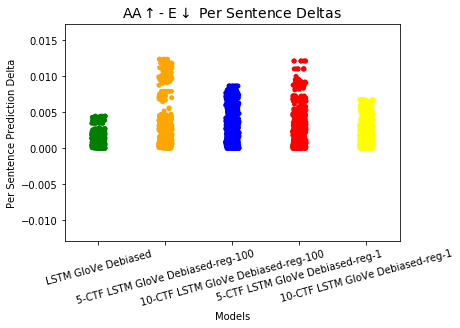

In [37]:
plot = seaborn.stripplot(data=_df_aa,palette=global_palette)
#plot.get_figure().savefig('../images/df_aa.png', format='png',dpi=300,bbox_inches='tight')
plot.set_xticklabels(labels=xticklabels,rotation=15)
plot.set(xlabel='Models', ylabel='Per Sentence Prediction Delta')
plot.set_title("AA$\uparrow$- E$\downarrow$ Per Sentence Deltas",{'fontsize':14})
for i in xticklabels:
    print(i, " mean ", np.mean(df_aa[i]),"range", np.min(np.abs(df_aa[i])),np.max(np.abs(df_aa[i])))
#plot.get_figure().savefig('../images/df_aa.png', format='png',dpi=300,bbox_inches='tight')